### CSV formatting

In [32]:
from pandas import concat
from pandas import read_csv

splits_files = list((base_path / 'datasets').glob('*.csv'))
dvh_files = [filename for filename in splits_files if 'DvH' in filename.name]
dvp_files = [filename for filename in splits_files if 'DvP' in filename.name]
hvp_files = [filename for filename in splits_files if 'HvP' in filename.name]

def load_and_concat(files):
    dfs = []
    for file in files:
        df = read_csv(file)
        df['split'] = file.stem.split('_')[-3]
        df = rearrange_columns(df)
        dfs.append(df)
    return concat(dfs, ignore_index=True)

def rearrange_columns(df):
    df = df.rename(columns={'age_at_image': 'age_at_scan'})
    df = df.drop(columns=['index', 'target', 'group'])
    df['image_path'] = df['image_path'].apply(lambda pth: str(pth).replace('/dccstor/fs_processing/xls-data_temp/', ''))
    df['image_path'] = df['image_path'].apply(lambda pth: pth.split('/')[0] + '/images_rigid/' + pth.split('/')[1])
    df['dataset'] = df['image_path'].apply(lambda pth: pth.split('/')[0])
    return df

def save_metadata_and_splits(df, data_name, base_path):
    metadata_path = base_path / data_name / 'metadata' / f'{data_name}_image_baseline_metadata.csv'
    splits_path = base_path / data_name / 'splits'
    splits_path.mkdir(parents=True, exist_ok=True)
    metadata_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(metadata_path, index=False)
    train_split = df[df['split'] == 'train']
    val_split = df[df['split'] == 'val']
    train_split.to_csv(splits_path / 'train.csv', index=False)
    val_split.to_csv(splits_path / 'val.csv', index=False)


dvh_df = load_and_concat(dvh_files)
dvp_df = load_and_concat(dvp_files)
hvp_df = load_and_concat(hvp_files)
save_metadata_and_splits(dvh_df, 'ad_vs_hc', base_path / 'datasets')
save_metadata_and_splits(dvp_df, 'ad_vs_mci', base_path / 'datasets')
save_metadata_and_splits(hvp_df, 'mci_vs_hc', base_path / 'datasets')

### RDMs analysis

#### Imports and declarations

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_rsa_histogram_grid(compared_rdms, layer, task):
    compared_rdms = compared_rdms[task]
    x_models = list(compared_rdms.keys())
    y_model_pairs = [(f'{y_model.split('_')[0]}_pretrained', f'{y_model.split('_')[0]}_finetuned') for y_model in x_models]
    
    sns.set_theme()
    fig, axes = plt.subplots(len(y_model_pairs), len(x_models), figsize=(10, 8))
    fig.tight_layout(pad=3.0)
    
    plt.subplots_adjust(top=0.9)
    parsed_task_title = task.replace('ad_vs_hc', 'AD and HC')
    parsed_task_title = parsed_task_title.replace('ad_vs_mci', 'AD and MCI')
    parsed_task_title = parsed_task_title.replace('mci_vs_hc', 'MCI and HC')
    fig.suptitle(f'RSA Analysis on {parsed_task_title} subjects for layer {layer}', fontsize=14)

    all_values = []
    for x_model in x_models:
        for y_pretrained, y_finetuned in y_model_pairs:
            all_values.extend(compared_rdms[x_model][y_pretrained][layer])
            all_values.extend(compared_rdms[x_model][y_finetuned][layer])
    global_min = min(all_values)
    global_max = max(all_values)
    padding = (global_max - global_min) * 0.05
    global_min -= padding
    global_max += padding
    
    # Add column labels (x-axis models)
    for col, x_model in enumerate(x_models):
        model_name = x_model.split('_')[0]
        if model_name == 'bmi': model_name = 'BMI'
        col_title = f'Similarity to {model_name} prediction model'
        axes[0, col].set_title(col_title, fontsize=11)
    
    # Add row labels (y-axis model pairs)
    for row, (pretrained, _) in enumerate(y_model_pairs):
        model_name = pretrained.split('_')[0].capitalize()
        if model_name == 'Bmi': model_name = 'BMI'
        ylabel = f'{model_name} prediction\n before and after fine-tuning'
        axes[row, 0].set_ylabel(ylabel, fontsize=10)
    
    # Set common x and y labels
    fig.text(0.5, 0.02, 'Correlation value', ha='center', fontsize=14)
    fig.text(0.02, 0.5, 'Similarity density', va='center', rotation='vertical', fontsize=14)
    
    pretrained_color = sns.color_palette()[0]
    finetuned_color = sns.color_palette()[1]
    for row, (y_pretrained, y_finetuned) in enumerate(y_model_pairs):
        for col, x_model in enumerate(x_models):
            ax = axes[row, col]
            ax.set_yticks([])
            if col > 0:
                ax.set_yticklabels([])
            if row < len(y_model_pairs) - 1:
                ax.set_xticks([])
            else:
                ax.tick_params(axis='x', labelsize=10)

            pretrained_data = compared_rdms[x_model][y_pretrained][layer]
            finetuned_data = compared_rdms[x_model][y_finetuned][layer]
            if row != col:            
                sns.kdeplot(pretrained_data, ax=ax, fill=True, alpha=0.5, color=pretrained_color,
                        label=f'vs {y_pretrained}', linewidth=1, bw_adjust=0.8, legend=False)
            else:
                ax.axvline(x=1, color=pretrained_color, lw=2, alpha=0.7)
            sns.kdeplot(finetuned_data, ax=ax, fill=True, alpha=0.5, color=finetuned_color,
                      label=f'vs {y_finetuned}', linewidth=1, bw_adjust=0.8, legend=False)

            ax.set_xlim(global_min, global_max)
            ax.grid(alpha=0.3)

    handles = [
        plt.Line2D([0], [0], color=pretrained_color, lw=4, alpha=0.7),
        plt.Line2D([0], [0], color=finetuned_color, lw=4, alpha=0.7)
    ]
    labels = ['Pretrained', 'Fine-tuned']
    fig.legend(handles, labels, fontsize=10, frameon=True, loc='upper left')
    
    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])  # Adjust the rect parameter to make room for labels
    
    return fig

In [2]:
from pretrain_exp.rsa import compare_models, plot_maps, plot_correlations, load_task_rdms
from pathlib import Path

base_path = Path('pretrain_exp')
rdms_file, batches_file = 'rdms.pkl', 'batches.pkl'
rdms_path = base_path / 'results'
tasks = ['ad_vs_hc', 'ad_vs_mci', 'mci_vs_hc']
models = ['age', 'sex', 'bmi', 'none']
layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6']
sample_size = 100
n_iters = 100
random_state = 42

/home/ftravi/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Compute comparisons

In [3]:
comparisons_dict = compare_models(tasks, models, layers, rdms_path, sample_size, n_iters, random_state)
print('Sample size (half of each class):', sample_size)
print('Number of iterations:', n_iters)

Sample size (half of each class): 100
Number of iterations: 100


### AD vs. HC

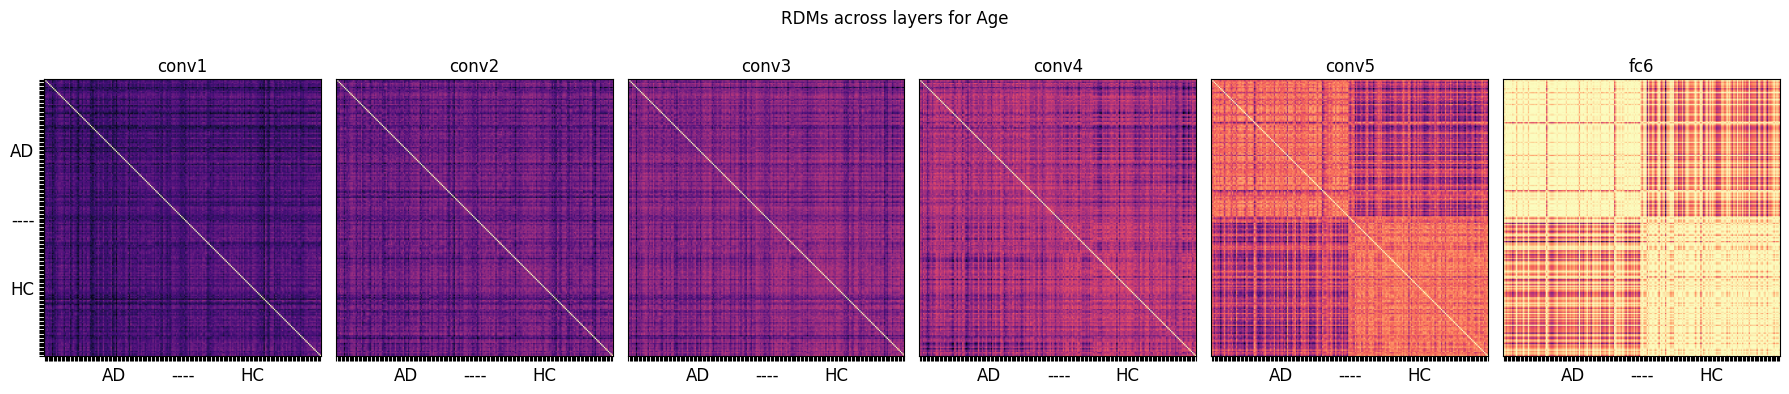

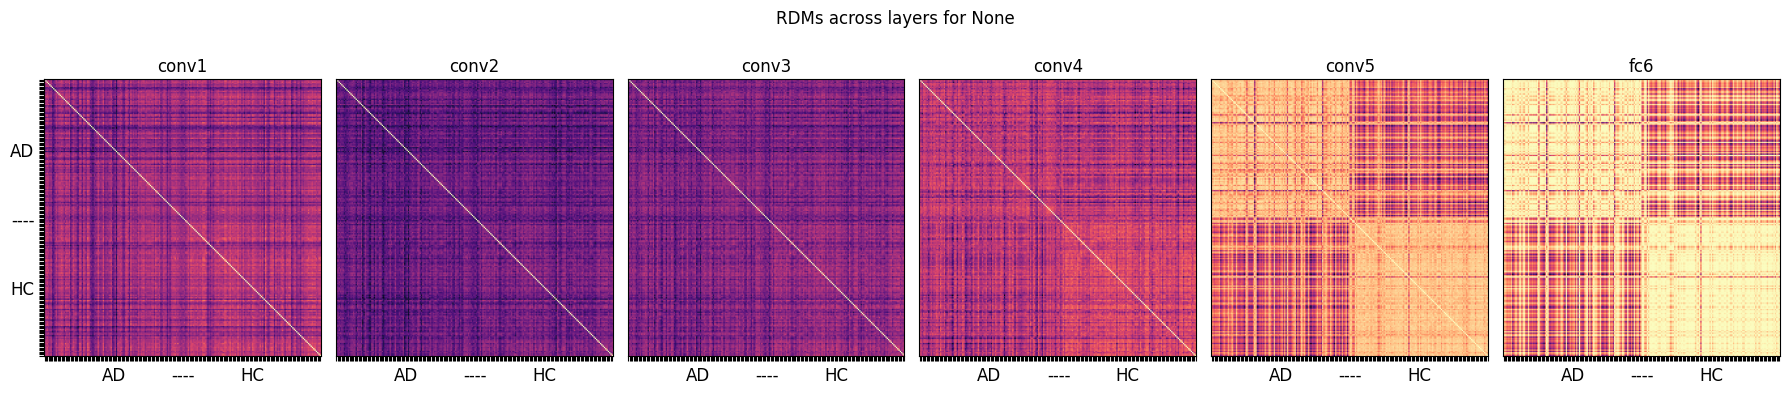

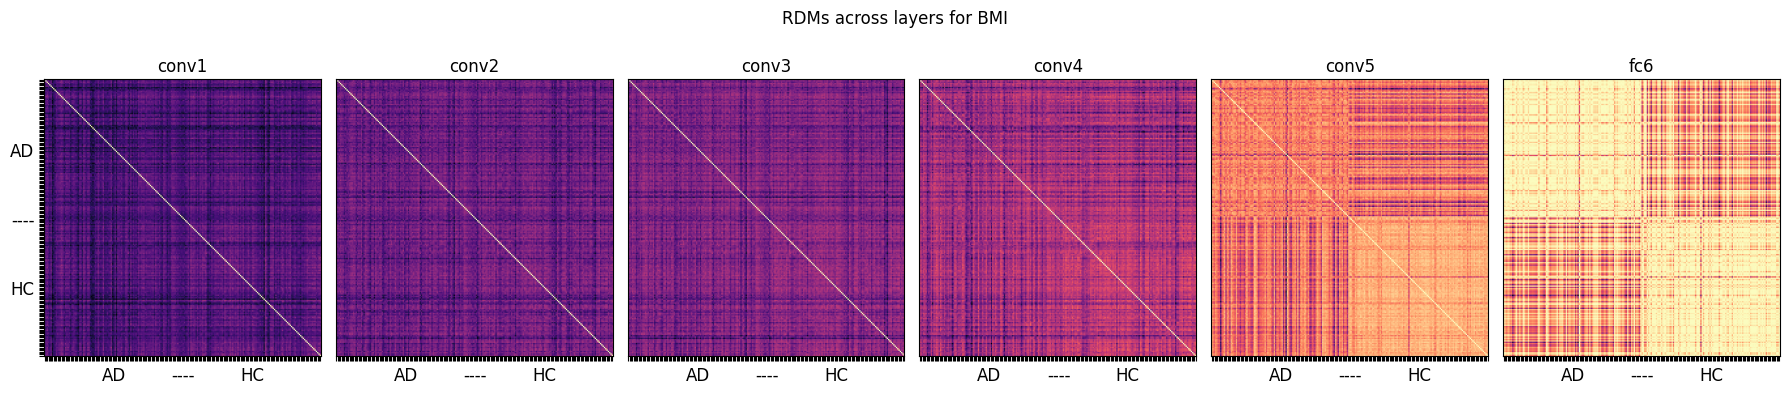

In [5]:
ad_vs_hc_rdms, _ = load_task_rdms(rdms_path, 'ad_vs_hc')
plot_maps(ad_vs_hc_rdms['age']['tl'], 'Age', ['AD', 'HC'])
plot_maps(ad_vs_hc_rdms['none']['tl'], 'None', ['AD', 'HC'])
tl_age_maps = plot_maps(ad_vs_hc_rdms['bmi']['tl'], 'BMI', ['AD', 'HC'])
# tl_age_maps = plot_maps(ad_vs_hc_rdms['age']['tl'], 'Age TL', ['AD', 'HC'])
# tl_age_maps.savefig(rdms_path / 'tl_age_maps.png', dpi=300)

#### No pretraining

In [ ]:
# plot_correlations(comparisons_dict['ad_vs_hc']['bmi_pretrained']['none_finetuned'], 'Non-pretrained model vs. BMI model on AD and HC subjects')
# plot_correlations(comparisons_dict['ad_vs_hc']['sex_pretrained']['none_finetuned'], 'Non-pretrained model vs. sex model on AD and HC subjects')
# plot_correlations(comparisons_dict['ad_vs_hc']['age_pretrained']['none_finetuned'], 'Non-pretrained model vs. age model on AD and HC subjects')

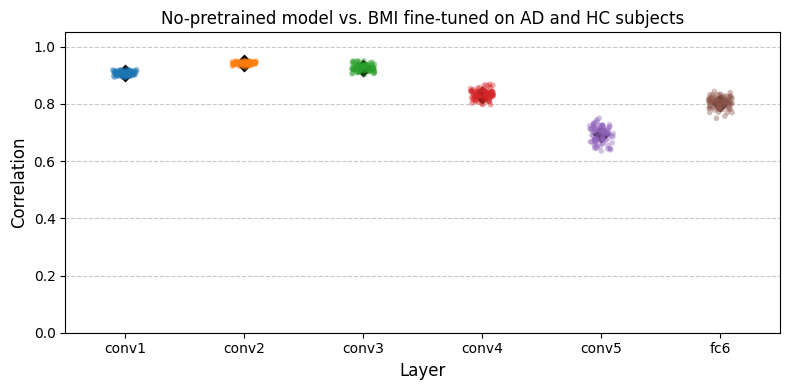

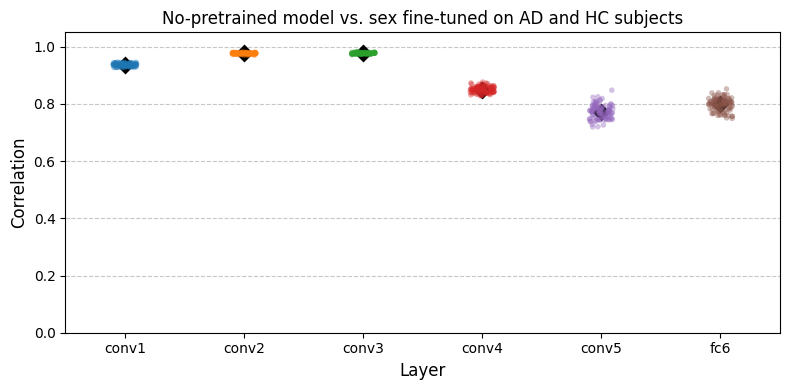

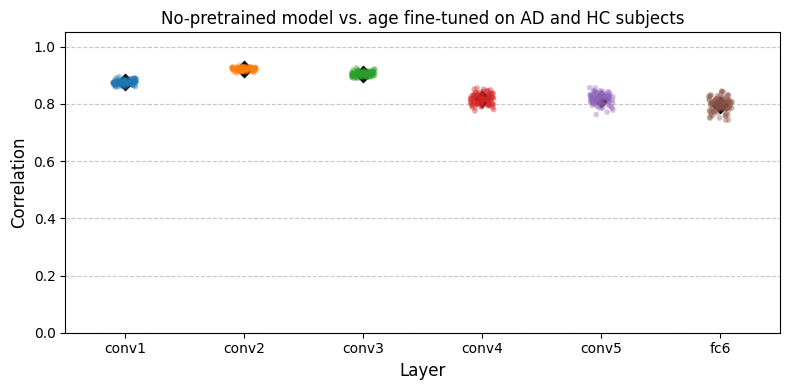

In [6]:
plot_correlations(comparisons_dict['ad_vs_hc']['none_pretrained']['bmi_finetuned'], 'Non-pretrained model vs. BMI fine-tuned on AD and HC subjects')
plot_correlations(comparisons_dict['ad_vs_hc']['none_pretrained']['sex_finetuned'], 'Non-pretrained model vs. sex fine-tuned on AD and HC subjects')
plot_correlations(comparisons_dict['ad_vs_hc']['none_pretrained']['age_finetuned'], 'Non-pretrained model vs. age fine-tuned on AD and HC subjects')

#### Pretrained vs. fine-tuned

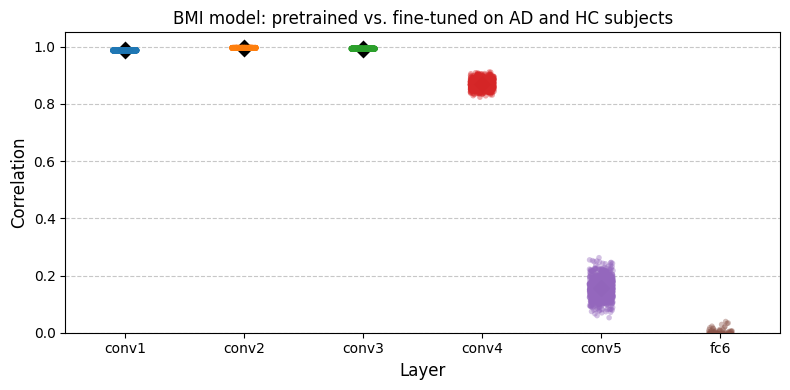

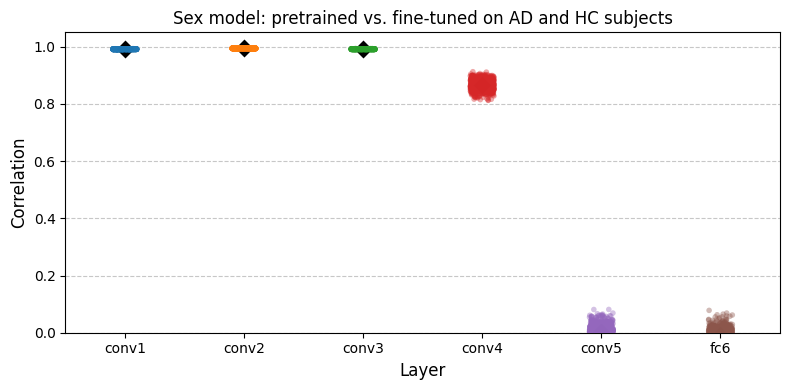

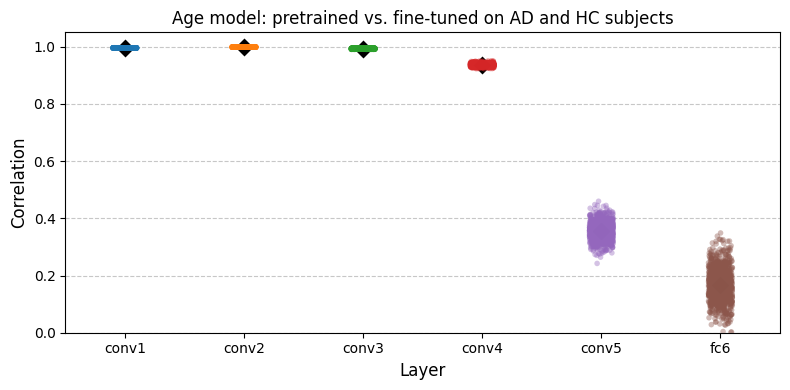

In [14]:
plot_correlations(comparisons_dict['ad_vs_hc']['bmi_pretrained']['bmi_finetuned'], 'BMI model: pretrained vs. fine-tuned on AD and HC subjects')
plot_correlations(comparisons_dict['ad_vs_hc']['sex_pretrained']['sex_finetuned'], 'Sex model: pretrained vs. fine-tuned on AD and HC subjects')
plot_correlations(comparisons_dict['ad_vs_hc']['age_pretrained']['age_finetuned'], 'Age model: pretrained vs. fine-tuned on AD and HC subjects')

#### Between pretrained modalities

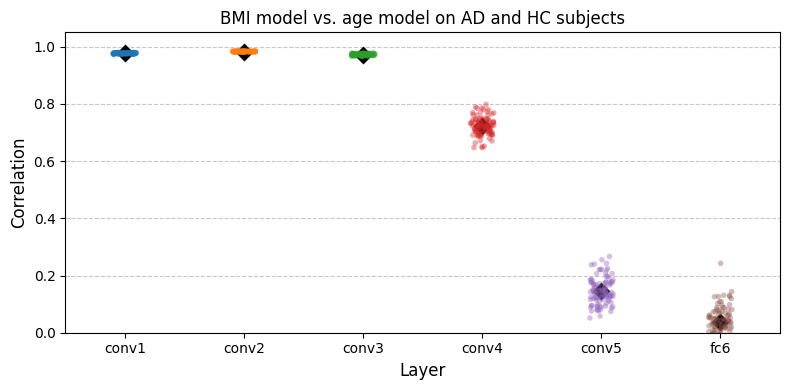

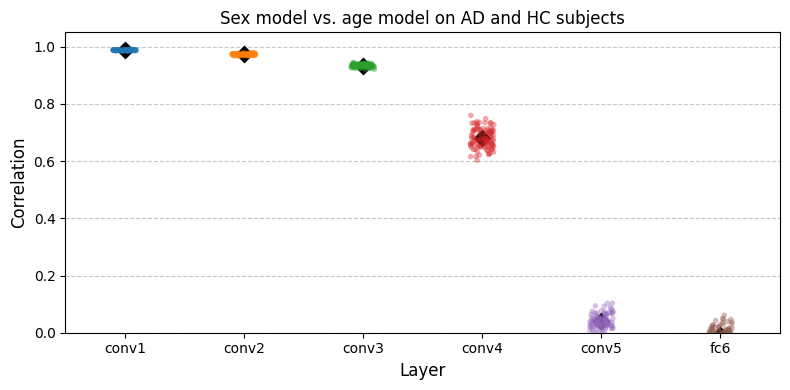

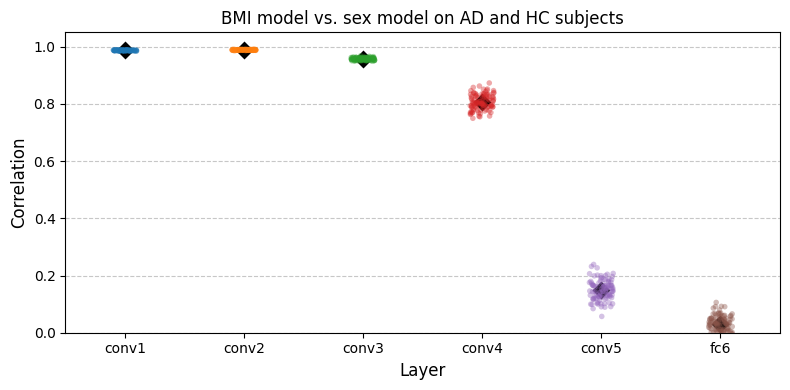

In [6]:
plot_correlations(comparisons_dict['ad_vs_hc']['bmi_pretrained']['age_pretrained'], 'BMI model vs. age model on AD and HC subjects')
plot_correlations(comparisons_dict['ad_vs_hc']['sex_pretrained']['age_pretrained'], 'Sex model vs. age model on AD and HC subjects')
plot_correlations(comparisons_dict['ad_vs_hc']['bmi_pretrained']['sex_pretrained'], 'BMI model vs. sex model on AD and HC subjects')

### Histogram similarity grid plot

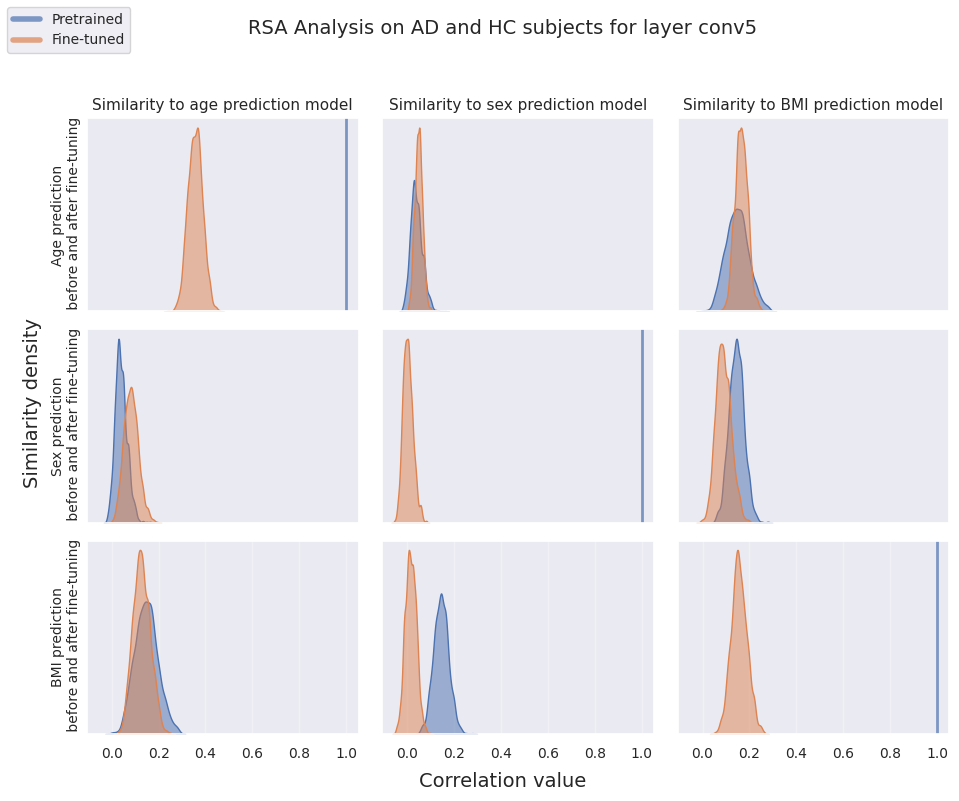

In [46]:
fig = plot_rsa_histogram_grid(comparisons_dict, 'conv5', task='ad_vs_hc')
fig.savefig(base_path / 'results' / 'rsa_histogram_ad_vs_hc_conv5.png', dpi=300, bbox_inches='tight')
plt.show()

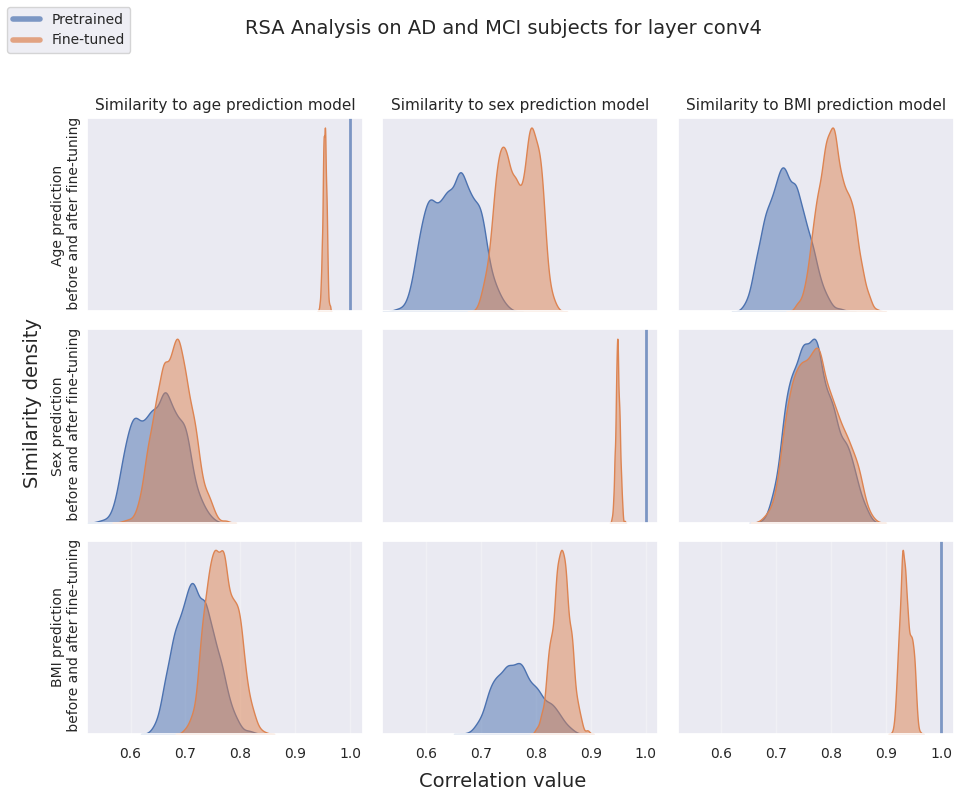

In [41]:
fig = plot_rsa_histogram_grid(comparisons_dict, 'conv4', task='ad_vs_mci')
fig.savefig(base_path / 'results' / 'rsa_histogram_ad_vs_mci_conv4.png', dpi=300, bbox_inches='tight')
plt.show()

#### MCI vs HC

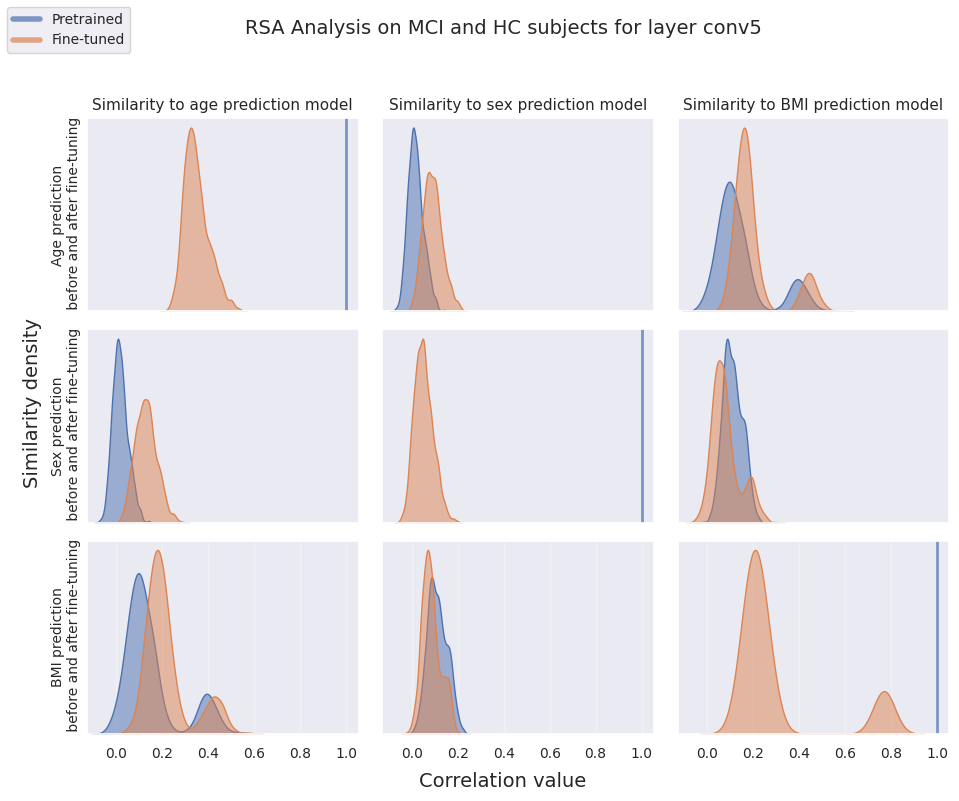

In [45]:
fig = plot_rsa_histogram_grid(comparisons_dict, 'conv5', task='mci_vs_hc')
fig.savefig(base_path / 'results' / 'rsa_histogram_mci_vs_hc_conv5.png', dpi=300, bbox_inches='tight')
plt.show()